# <font color ='545aa7'> Chapter 11: Nuclear Magnetic Resonance with NMRglue </font>

From **Scientific Computing for Chemists** by Charles Weiss. The document is copyright © 2021 Charles J. Weiss and is released under under the [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

In [22]:
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 11.1 NMR Processing

## 11.2 Importing Data with NMRglue

In [23]:
dic, data = ng.pipe.read('EtPh_1H_NMR_CDCl3.fid')
data

array([-0.00194889-0.00471539j, -0.00192186-0.00472489j,
       -0.00191337-0.00473085j, ..., -0.00189737+0.00591656j,
       -0.00191882+0.005872j  , -0.00191135+0.00587132j], dtype=complex64)

#### Note
The data used in this demo was already Fourier transformed on the spectrometer, so the following cell reverses this process for demo purposed. The udic also reflects that it was already Fourier transformed. 

In [24]:
# Reversed the Fourier transform for demo purposes being as this data was colleced on a spectrometer
# that already Fourier transformed the data.

from scipy.fftpack import ifft
data = ifft(data)[::-1]

In [25]:
udic = ng.pipe.guess_udic(dic, data)
udic

{'ndim': 1,
 0: {'sw': 5994.65478515625,
  'complex': True,
  'obs': 399.7821960449219,
  'car': 1998.9109802246094,
  'size': 13107,
  'label': 'Proton',
  'encoding': 'direct',
  'time': False,
  'freq': True}}

## 11.3 Fourier Transforming Data

In [26]:
udic[0]['time']

False

In [27]:
fig0 = plt.figure(figsize=(16,6))
ax0 = fig0.add_subplot(1,1,1)
ax0.plot(data.real)

In [28]:
from scipy.fft import fft  # imports only fft function
fdata = fft(data)

In [29]:
fig1 = plt.figure(figsize=(16,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(fdata.real)
plt.gca().invert_xaxis()

## 11.4 Phasing Data
### 11.4.1 Autophasing

In [30]:
phased_data = ng.process.proc_autophase.autops(fdata,'acme')

Optimization terminated successfully.
         Current function value: 0.001729
         Iterations: 120
         Function evaluations: 238


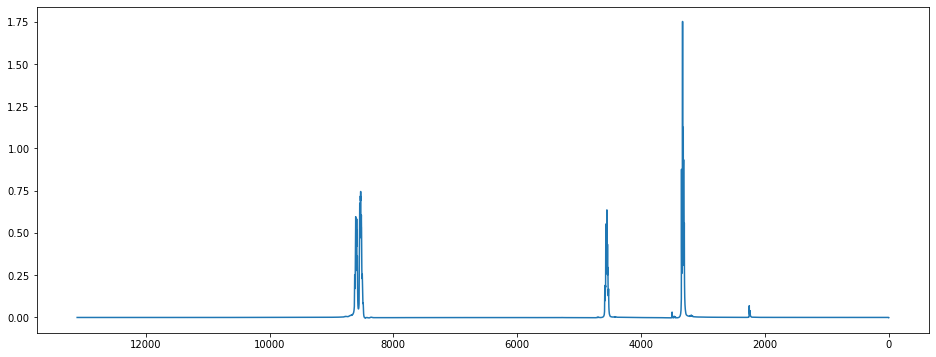

In [31]:
fig2 = plt.figure(figsize=(16,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(phased_data.real)
plt.gca().invert_xaxis()

### 11.4.2 Manual Phasing

## 11.5 Chemical Shift
### 11.5.1 Generate the X-Axis

In [32]:
size = udic[0]['size'] # points in data
sw = udic[0]['sw']     # width in Hz
obs = udic[0]['obs']   # carrier frequency

In [33]:
from math import floor
hz = np.linspace(0, floor(sw), size) # x-axis in Hz 
ppm = hz / obs                       # x-axis in ppm

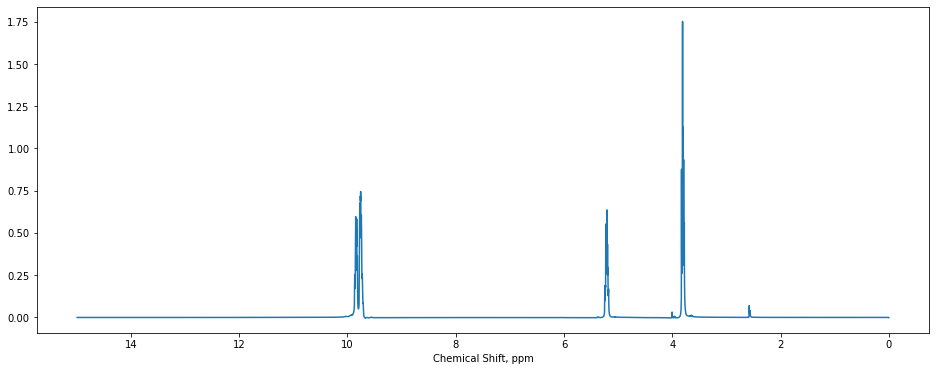

In [34]:
fig4 = plt.figure(figsize=(16,6))
ax4 = fig4.add_subplot(1,1,1)
ax4.plot(ppm, phased_data.real)
ax4.set_xlabel('Chemical Shift, ppm')
plt.gca().invert_xaxis()

### 11.5.2 Referencing the Data

In [35]:
point_shift = int((-2.5782 * size * obs) / sw)
data_ref = np.roll(phased_data, point_shift)

In [36]:
point_shift

-2253

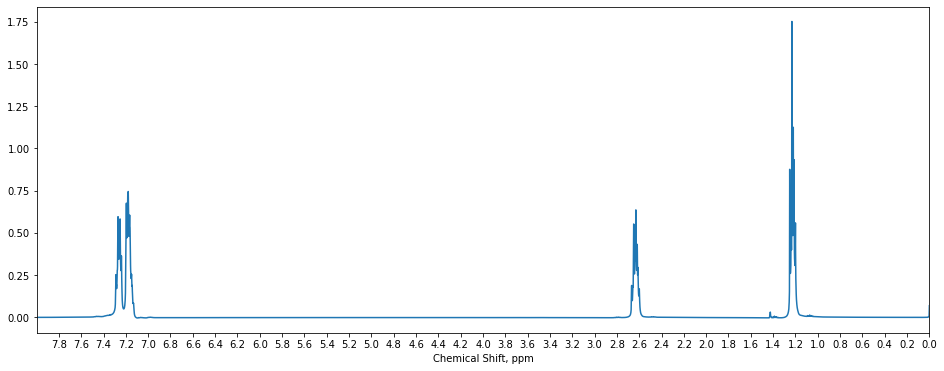

In [37]:
fig5 = plt.figure(figsize=(16,6))
ax6 = fig5.add_subplot(1,1,1)
ax6.plot(ppm, data_ref.real)
ax6.set_xlabel('Chemical Shift, ppm')
plt.xlim(8,0)
plt.xticks(np.arange(0,8,0.2))
plt.show()

#plt.savefig('reference_ppm_data.png', dpi=300, format='PNG')

## 11.6 Integration

In [38]:
uc = ng.pipe.make_uc(dic, data)

In [39]:
limits = np.array([[7.07,7.37], [1.10, 1.35], [2.50,2.75]])

In [40]:
fig6 = plt.figure(figsize=(16,6))
ax6 = fig6.add_subplot(1,1,1)
ax6.plot(ppm, data_ref.real)
ax6.set_xlabel('Chemical Shift, ppm')
plt.xlim(8,0)
plt.xticks(np.arange(0,8,0.2))
for lim in limits.flatten():
    plt.axvline(lim, c='r')

In [41]:
area = ng.analysis.integration.integrate(data_ref.real, uc, limits)
area

array([-0.00061348, -0.00035478, -0.00034138], dtype=float32)

In [42]:
area / np.min(area)

array([1.        , 0.5783051 , 0.55646706], dtype=float32)

## 11.7 Peak Picking

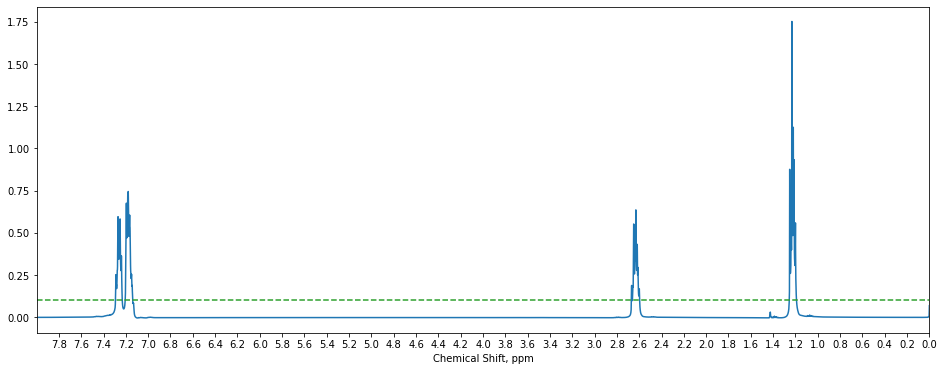

In [43]:
fig7 = plt.figure(figsize=(16,6))
ax7 = fig7.add_subplot(1,1,1)
ax7.plot(ppm, data_ref.real)
ax7.set_xlabel('Chemical Shift, ppm')
plt.xlim(8,0)
plt.xticks(np.arange(0,8,0.2))
plt.axhline(0.1, c='C2', ls='--')

In [44]:
peaks = ng.analysis.peakpick.pick(data_ref.real, pthres=0.1)
peaks

rec.array([(1077., 1, 34.1857841 , 27.63016701),
           (2299., 2, 31.36229494, 16.87085152),
           (2332., 3,  5.        ,  0.88378525),
           (6275., 4, 35.96975553, 25.60304451),
           (6355., 5, 32.1389443 , 17.82140732)],
          dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')])

In [45]:
peak_loc = []
for x in peaks:
    peak_loc.append(ppm[int(x[0])])
print(peak_loc)

[1.2320797763091693, 2.6300384454361936, 2.6677901934568085, 7.178552085738197, 7.2700714748790825]


In [46]:
fig8 = plt.figure(figsize=(16,6))
ax8 = fig8.add_subplot(1,1,1)
ax8.plot(ppm, data_ref.real)
ax8.set_xlabel('Chemical Shift, ppm')
plt.xlim(8,0)
plt.xticks(np.arange(0,8,0.2))
for p in peak_loc:
    plt.axvline(p, c='C1', ls='--', alpha=1)
#plt.savefig('peak_loc_reference_ppm_data.png', dpi=300, format='PNG')

## Exercises

1. Open the 1H NMR spectrum of ethanol, **EtOH_1H_NMR.fid**, taken in CDCl$_3$ with TMS using NMRglue.

a) Plot the resulting spectrum and be sure to properly reference it.

b) Integrate the methyl (CH$_3$) versus the methylene (-CH$_2$-) resonances and calculate the ratio.


2. Open the $^1$H and $^{13}$C NMR spectra of 2-ethyl-1-hexanol, **2-ethyl-1-hexanol_1H_NMR_CDCl3.fid** and **2-ethyl-1-hexanol_13C_NMR_CDCl3.fid**, in CDCl$_3$ with TMS and plot them on a ppm scale. Be sure to properly phase and reference the spectra.